# Huggingface transformers를 활용한 LAMA(LAnguage Model Analysis) 실습

본 실습에서는 Pretrained Language Model에 담겨 있는 지식을 직접 확인하는 예제를 다루게 됩니다.


먼저 노트북을 실행하는데에 필요한 라이브러리 설치와 데이터셋 파일을 준비해봅시다.

In [1]:
! pip install datasets transformers numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00


In [2]:
!wget https://raw.githubusercontent.com/bwookwak/bigdata_lm_knowledge/main/birth_dev.tsv

--2023-05-01 14:20:09--  https://raw.githubusercontent.com/bwookwak/bigdata_lm_knowledge/main/birth_dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20041 (20K) [text/plain]
Saving to: ‘birth_dev.tsv’

birth_dev.tsv       100%[===================>]  19.57K  --.-KB/s    in 0s      

2023-05-01 14:20:09 (114 MB/s) - ‘birth_dev.tsv’ saved [20041/20041]



gpu가 정상적으로 배정되었는지 확인합니다.

In [3]:
!nvidia-smi

Mon May  1 14:20:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

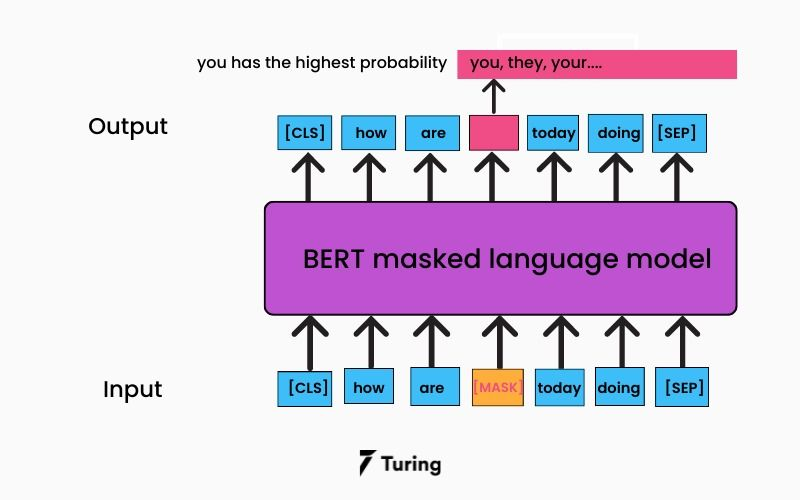

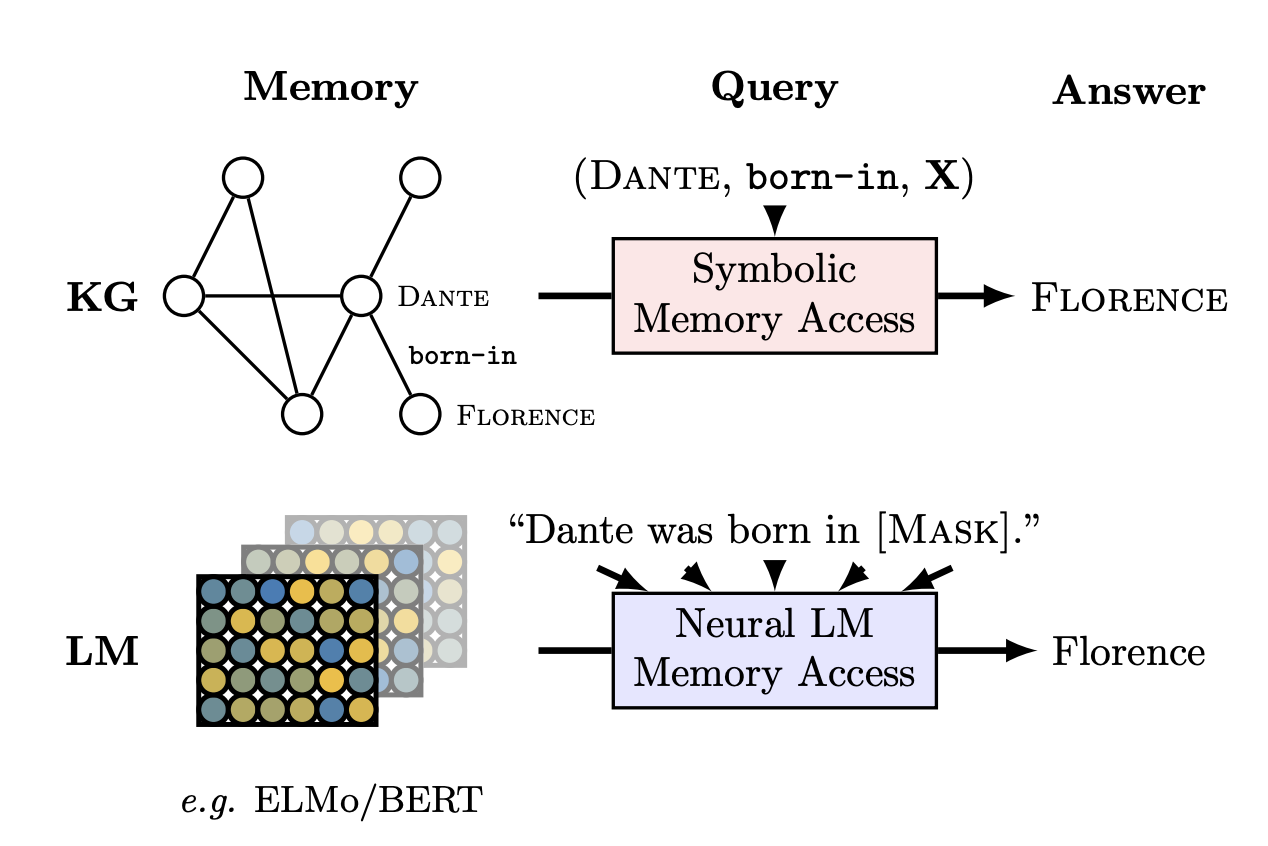

In [4]:
import torch
import numpy as np
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import tqdm

이번 실습에서는 Huggingface tokenizer를 최소한으로만 사용하여 구현을 진행하겠습니다. 

같은 기능을 가지고 있는 함수들이 이미 구현되어 있지만 ([DOC](https://huggingface.co/docs/transformers/main_classes/tokenizer)) 실제 input이 어떻게 구성되고 어떤점을 고려해야하는지에 대해서 구현을 하면서 알아보겠습니다. 

tokenizer는 vocab 을 필요로 합니다. Vocab은 token 과 token 고유의 index를 가지고 있습니다.

In [5]:
with open('/content/birth_dev.tsv', 'r') as fp:
  text = fp.read()

In [6]:
class LamaPadDataset(Dataset):
    def __init__(self, data, tokenizer, max_len = -1):
        self.max_len = max_len

        self.MASK_CHAR = tokenizer.mask_token
        self.PAD_CHAR = tokenizer.pad_token
        self.CLS_CHAR = tokenizer.cls_token
        self.SEP_CHAR = tokenizer.sep_token
        self.tokenizer = tokenizer

        self.stoi = tokenizer.vocab
        self.itos = {value : key for key, value in (tokenizer.vocab).items()}
 
        self.data = data.split('\n')[:-1]

    # max_length를 넉넉하게 잡고 자리가 남는 다면 나머지 부분을 PAD_CHAR로 채워볼까요?
    # padding된 input과 padding하기 전의 길이를 리턴해봅시다.
    # input : tokenized input
    # output : padding된 input
    def pad(self, input): 
        if (self.max_len - len(input)) >= 0:
          input = input + [self.PAD_CHAR] * (self.max_len - len(input))
        return input
    def __len__(self):
        # returns the length of the dataset
        return len(self.data)
    def __getitem__(self, idx):
    
        inp, oup = self.data[idx].split('\t')
        inp = inp.replace('Where was ','').replace('born','was born in ').replace('?','')
        x = self.CLS_CHAR +' '+ inp + self.MASK_CHAR + '.' +self.SEP_CHAR
        y = oup
        x = [x.strip() for x in self.tokenizer.tokenize(x)]
        y = self.tokenizer.tokenize(y)
        label_inds = torch.tensor([x.index(self.MASK_CHAR)])

        x = self.pad(x)

        x = torch.tensor([self.stoi[c] for c in x], dtype=torch.long)
        y = torch.tensor([self.stoi[c] for c in y], dtype=torch.long)

        token_type_ids = torch.tensor([0 for _ in range(len(x))])

        # PAD 부터는 attention이 계산되는걸 막기 위해 mask라는 것을 사용해봅시다.
        # attention 연산이 계산되어야 하는 token의 position에는 1(True), 아닌 token(padding)에는 0(False)이 채워진 tensor를 만들어 봅시다.
        # 예) tensor([i, like, dogs, PAD, PAD]) -> tensor([True,True,True,False,False])
        attention_mask = (x != torch.tensor([self.stoi[self.PAD_CHAR]]))

        return {"input_ids" : x, "token_type_ids" : token_type_ids, "attention_mask" : attention_mask}, y, label_inds



# Evaluation

In [7]:
def eval_acc(model, dataloader):
  model.eval()
  predictions = []
  labels = []
  for batch in tqdm.tqdm(dataloader):
    inputs, label, label_inds = batch
    inputs = {x: inputs[x].to('cuda') for x in inputs}
    label = label.to('cuda')
    with torch.no_grad():
      pred = model(**inputs)
    prediction = np.array([pred.logits.cpu().detach().numpy()[i, label_inds[i], :] for i in range(len(label_inds))])
    prediction = np.argmax(prediction, axis = 1)
    predictions.extend(prediction.tolist())
    labels.extend(label.flatten().tolist())

  correct = 0
  total = 0
  for p,l in zip(predictions, labels):
    if int(p) == int(l):
      correct += 1
    total += 1
  
  return correct / total * 100

***

#과제 (40점 만점 = 15 + 25)

## 과제 1. 모델의 사이즈가 달라진다면 성능이 다를까요? (15점)

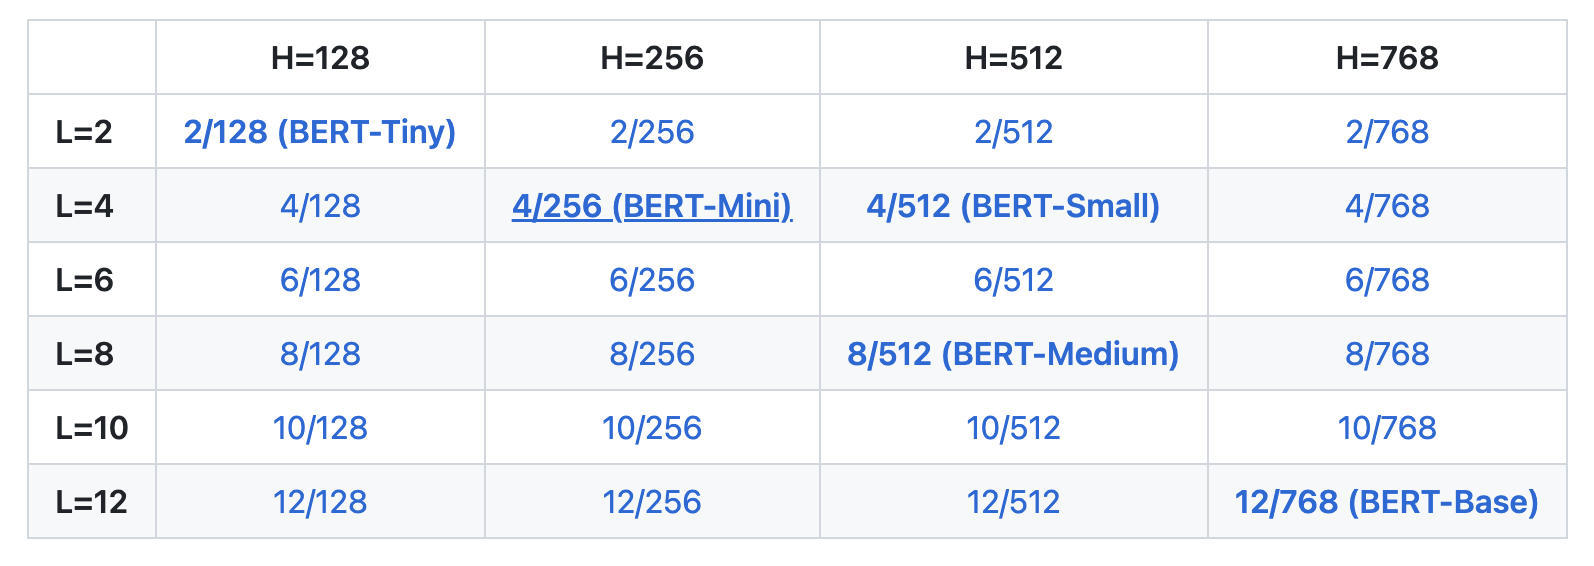

### 보고서 내용

1. 모델 별 프린트된 성능 (10점)

2. 배운 것을 토대로 추측할 수 있는 이유 (5점)

를 작성해주시면 됩니다.

### 힌트
* 모델의 사이즈가 커진다는 것은..

### 모델리스트
* Bert-Tiny : "prajjwal1/bert-tiny"
* Bert-Small : "prajjwal1/bert-small"
* Bert-Large : "bert-large-cased"

In [8]:
# 사용할 pretrained 모델 이름 간단하게 하려고 만들어놓은 딕셔너리
MODEL_NAME_TO_CLASS = {
    'bert' : 'bert-base-cased',
    'bert-tiny' : "prajjwal1/bert-tiny",
    'bert-small' : "prajjwal1/bert-small",
    'bert-large' : "bert-large-cased"
}

def build_model_by_name(lm):
    """Load a model by name and args.
    Note, args.lm is not used for model selection. args are only passed to the
    model's initializator.
    """
    if lm not in MODEL_NAME_TO_CLASS:
        raise ValueError("Unrecognized Language Model: %s." % lm)
    return AutoModelForMaskedLM.from_pretrained(MODEL_NAME_TO_CLASS[lm])

def build_tokenizer_by_name(lm):
    """Load a model by name and args.
    Note, args.lm is not used for model selection. args are only passed to the
    model's initializator.
    """
    if lm not in MODEL_NAME_TO_CLASS:
        raise ValueError("Unrecognized Language Model: %s." % lm)
    return AutoTokenizer.from_pretrained(MODEL_NAME_TO_CLASS[lm])



In [9]:
modelnames = ['bert-tiny', 'bert-small', 'bert-large']

In [10]:
accs = []
for modelname in modelnames:
  model = build_model_by_name(modelname).to('cuda')
  tokenizer = build_tokenizer_by_name(modelname)

  dev_dataset = LamaPadDataset(text, tokenizer, max_len = 25)
  dataloader = DataLoader(dev_dataset, batch_size = 50, shuffle = False)

  acc = eval_acc(model, dataloader)
  accs.append(acc)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████| 10/10 [01:00<00:00,  6.08s/it]


Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████| 10/10 [00:55<00:00,  5.51s/it]


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


In [11]:
for mname, acc in zip(modelnames, accs):
  print(f'Accuracy for \'{mname}\': {round(acc, 1)}%')

Accuracy for 'bert-tiny': 4.2%
Accuracy for 'bert-small': 9.8%
Accuracy for 'bert-large': 13.2%


***

## 과제 2. input을 바꾸지 않고 쓰면 어떻게 될까요? (25점)

"Where was Bryan Dubreuiel born?" -> "Bryan Dubreuiel was born in "로 바꿨던걸 

"Where was Bryan Dubreuiel born?" 이대로 쓰면 어떻게 될지 테스트 해봅시다. 

최종 인풋이 "[CLS] Where was Bryan Dubreuiel born? [MASK] [SEP]." 와 같은 형태로 구성되면 됩니다.

### 보고서 내용
1. 프린트된 성능 (5점)
2. predictions 변수에 담겨 있는 index를 다시 token으로 바꿔서 어떤 token인지 프린트한 결과 (5점)
3. 배운 것을 토대로 추측할 수 있는 이유 (5점)
4. 그렇다면 어떻게 하면 모델에 저장된 knowledge를 바꿔줄 수 있을까? (5점)
5. 4번에서 제시한 방법에 단점은 뭐가 있을까요? (5점)


### 힌트 
* 3번 힌트 : BERT 는 **Web Corpus**를 이용한 **Pretrained** 모델이죠
* 4번 힌트 : Pretrain and {}, etc ...
* 4번은 BERT 뿐만이 아니라 ChatGPT를 써보신 분이라면 ChatGPT에서 바꾸는 법을 소개하셔도 됩니다.

In [35]:
class NewLamaPadDataset(Dataset):
    def __init__(self, data, tokenizer, max_len = -1):
        self.max_len = max_len

        self.MASK_CHAR = tokenizer.mask_token
        self.PAD_CHAR = tokenizer.pad_token
        self.CLS_CHAR = tokenizer.cls_token
        self.SEP_CHAR = tokenizer.sep_token
        self.tokenizer = tokenizer

        self.stoi = tokenizer.vocab
        self.itos = {value : key for key, value in (tokenizer.vocab).items()}
 
        self.data = data.split('\n')[:-1]

    # max_length를 넉넉하게 잡고 자리가 남는 다면 나머지 부분을 PAD_CHAR로 채워볼까요?
    # padding된 input과 padding하기 전의 길이를 리턴해봅시다.
    # input : tokenized input
    # output : padding된 input
    def pad(self, input): 
        if (self.max_len - len(input)) >= 0:
          input = input + [self.PAD_CHAR] * (self.max_len - len(input))
        return input
    def __len__(self):
        # returns the length of the dataset
        return len(self.data)
    def __getitem__(self, idx):
    
        inp, oup = self.data[idx].split('\t')
        x = self.CLS_CHAR + ' ' + inp + ' ' + self.MASK_CHAR + ' .' + self.SEP_CHAR
        y = oup
        x = [x.strip() for x in self.tokenizer.tokenize(x)]
        y = self.tokenizer.tokenize(y)
        label_inds = torch.tensor([x.index(self.MASK_CHAR)])

        x = self.pad(x)

        x = torch.tensor([self.stoi[c] for c in x], dtype=torch.long)
        y = torch.tensor([self.stoi[c] for c in y], dtype=torch.long)

        token_type_ids = torch.tensor([0 for _ in range(len(x))])

        # PAD 부터는 attention이 계산되는걸 막기 위해 mask라는 것을 사용해봅시다.
        # attention 연산이 계산되어야 하는 token의 position에는 1(True), 아닌 token(padding)에는 0(False)이 채워진 tensor를 만들어 봅시다.
        # 예) tensor([i, like, dogs, PAD, PAD]) -> tensor([True,True,True,False,False])
        attention_mask = (x != torch.tensor([self.stoi[self.PAD_CHAR]]))

        return {"input_ids" : x, "token_type_ids" : token_type_ids, "attention_mask" : attention_mask}, y, label_inds

In [36]:
modelnames = ['bert-tiny', 'bert-small', 'bert-large']

In [37]:
accs = []
for modelname in modelnames:
  model = build_model_by_name(modelname).to('cuda')
  tokenizer = build_tokenizer_by_name(modelname)

  dev_dataset = NewLamaPadDataset(text, tokenizer, max_len = 25)
  dataloader = DataLoader(dev_dataset, batch_size = 50, shuffle = False)

  acc = eval_acc(model, dataloader)
  accs.append(acc)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10/10 [00:52<00:00,  5.21s/it]
Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.

In [38]:
for mname, acc in zip(modelnames, accs):
  print(f'Accuracy for \'{mname}\': {round(acc, 1)}%')

Accuracy for 'bert-tiny': 0.0%
Accuracy for 'bert-small': 0.0%
Accuracy for 'bert-large': 0.0%


In [39]:
def predictions(model, dataloader):
  model.eval()
  predictions = []
  for batch in tqdm.tqdm(dataloader):
    inputs, label, label_inds = batch
    inputs = {x: inputs[x].to('cuda') for x in inputs}
    with torch.no_grad():
      pred = model(**inputs)
    prediction = np.array([pred.logits.cpu().detach().numpy()[i, label_inds[i], :] for i in range(len(label_inds))])
    prediction = np.argmax(prediction, axis = 1)
    predictions.extend(prediction.tolist())
  
  return predictions

In [40]:
model = build_model_by_name('bert-large').to('cuda')
tokenizer = build_tokenizer_by_name('bert-large')

dev_dataset = NewLamaPadDataset(text, tokenizer, max_len = 25)
dataloader = DataLoader(dev_dataset, batch_size = 50, shuffle = False)

pred = predictions(model, dataloader)
itos = {value : key for key, value in (tokenizer.vocab).items()}
print([itos[x] for x in pred])

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10/10 [00:56<00:00,  5.64s/it]

['No', 'No', '.', 'No', '.', '.', 'No', '.', 'No', '.', '.', 'No', 'No', 'No', '.', '.', 'No', 'No', '.', '.', 'No', '.', '.', 'No', '.', '.', 'No', 'No', '.', '.', 'No', '.', '.', '.', '.', '.', 'No', '.', 'No', '.', '.', '.', 'No', ')', '.', '.', '.', '.', '.', 'No', 'No', '?', 'No', '?', 'No', 'No', 'No', '.', '.', '.', 'No', '.', ')', 'No', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'No', 'No', '.', 'No', 'No', '.', 'No', 'No', 'No', '.', '.', 'No', 'No', 'No', '.', '.', 'No', '.', 'No', '.', 'No', 'No', '.', 'No', 'No', '.', 'No', '.', '.', '.', '.', '?', 'No', 'No', '.', 'No', '.', '.', '.', 'No', '.', '.', '.', '?', '.', 'No', 'No', '.', '.', '.', '.', 'No', '.', '.', '.', 'No', '.', '.', 'No', '.', '.', '.', '.', '.', 'No', '.', 'No', 'No', 'No', '.', '.', 'No', 'No', '.', '.', '.', '.', 'No', 'No', '.', '.', '.', '.', 'No', '.', '.', '.', '.', '.', '.', '.', '.', 'No', 'No', 'No', '.', 'No', '.', '.', 'No', 'No', 'No', 'No', '.', 'No', '.', '.', '.', 'No', 'No', '.', '?